# Encode and model and predict

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
%run '../modules/mongodb.py'
%run '../modules/xgboost.py'

In [3]:
color_code = {
    'Red': 0,
    'Blue': 1
}

In [4]:
mongodb = MongoDB()
mongoufc = mongodb.client()['ufc']
cur = mongoufc.processing.find({})
original = pd.DataFrame(cur)
original.drop(columns=['_id'], inplace=True)
original.head()

,r_odds,b_odds,r_ev,b_ev,date,winner,title_bout,weight_class,gender,no_of_rounds,...,r_height_cms,r_reach_cms,r_weight_lbs,r_age,b_age,empty_arena,b_match_weightclass_rank,r_match_weightclass_rank,b_pound_for_pound_rank,better_rank
0,-150,130,66.667,130,2021-10-02,0,False,Light Heavyweight,MALE,5,...,187.96,193.04,205,37,29,1,10,5,<NA>,Red
1,170,-200,170.0,50,2021-10-02,1,False,Welterweight,MALE,3,...,180.34,193.04,170,33,32,1,<NA>,<NA>,<NA>,neither
2,110,-130,110.0,76,2021-10-02,1,False,Middleweight,MALE,3,...,190.5,195.58,205,34,32,1,<NA>,<NA>,<NA>,neither
3,-675,475,14.815,475,2021-10-02,0,False,Lightweight,MALE,3,...,175.26,182.88,155,29,32,1,<NA>,<NA>,<NA>,neither
4,-135,115,74.074,115,2021-10-02,1,False,Lightweight,MALE,3,...,175.26,177.8,155,28,33,1,<NA>,<NA>,<NA>,neither


In [5]:
lol = original.isna().sum()
lol[lambda x : x > 0]

Series([], dtype: int64)

In [6]:
original = original.replace(r'^\s*$', np.nan, regex=True)
original = original.replace('<NA>', np.nan, regex=True)
df = original.copy()
df.head()

,r_odds,b_odds,r_ev,b_ev,date,winner,title_bout,weight_class,gender,no_of_rounds,...,r_height_cms,r_reach_cms,r_weight_lbs,r_age,b_age,empty_arena,b_match_weightclass_rank,r_match_weightclass_rank,b_pound_for_pound_rank,better_rank
0,-150,130,66.667,130,2021-10-02,0,False,Light Heavyweight,MALE,5,...,187.96,193.04,205,37,29,1,10,5,NaN,Red
1,170,-200,170.0,50,2021-10-02,1,False,Welterweight,MALE,3,...,180.34,193.04,170,33,32,1,NaN,NaN,NaN,neither
2,110,-130,110.0,76,2021-10-02,1,False,Middleweight,MALE,3,...,190.5,195.58,205,34,32,1,NaN,NaN,NaN,neither
3,-675,475,14.815,475,2021-10-02,0,False,Lightweight,MALE,3,...,175.26,182.88,155,29,32,1,NaN,NaN,NaN,neither
4,-135,115,74.074,115,2021-10-02,1,False,Lightweight,MALE,3,...,175.26,177.8,155,28,33,1,NaN,NaN,NaN,neither


## String to correct type

In [7]:
lol = original.isna().sum() # this is normal
indexes = lol[lambda x : x > 0].index
indexes = list(indexes)
lol[lambda x : x > 0]

b_avg_sig_str_landed         898
b_avg_sig_str_pct            739
b_avg_sub_att                803
b_avg_td_landed              804
b_avg_td_pct                 813
r_avg_sig_str_landed         443
r_avg_sig_str_pct            348
r_avg_sub_att                348
r_avg_td_landed              348
r_avg_td_pct                 358
b_match_weightclass_rank    3891
r_match_weightclass_rank    3450
b_pound_for_pound_rank      4715
dtype: int64

In [8]:
avgs = list(filter(lambda x : 'avg' in x, indexes))
avgs

['b_avg_sig_str_landed',
 'b_avg_sig_str_pct',
 'b_avg_sub_att',
 'b_avg_td_landed',
 'b_avg_td_pct',
 'r_avg_sig_str_landed',
 'r_avg_sig_str_pct',
 'r_avg_sub_att',
 'r_avg_td_landed',
 'r_avg_td_pct']

In [9]:
for avg in avgs:
    df[avg] = df[avg].astype('float32')
    
df[avgs].dtypes

b_avg_sig_str_landed    float32
b_avg_sig_str_pct       float32
b_avg_sub_att           float32
b_avg_td_landed         float32
b_avg_td_pct            float32
r_avg_sig_str_landed    float32
r_avg_sig_str_pct       float32
r_avg_sub_att           float32
r_avg_td_landed         float32
r_avg_td_pct            float32
dtype: object

In [10]:
df[avgs].isna().sum()

b_avg_sig_str_landed    898
b_avg_sig_str_pct       739
b_avg_sub_att           803
b_avg_td_landed         804
b_avg_td_pct            813
r_avg_sig_str_landed    443
r_avg_sig_str_pct       348
r_avg_sub_att           348
r_avg_td_landed         348
r_avg_td_pct            358
dtype: int64

In [11]:
# for avg in avgs:
#     df.loc[df[avg].isna(), avg] = df[avg].median()
# df[avgs].isna().sum()

In [12]:
streaks = list(filter(lambda x : 'streak' in x, list(df.columns)))
print(df[streaks].dtypes)
df[streaks] = df[streaks].astype('int32')
print(df[streaks].dtypes)

df[streaks].isna().sum()

b_current_lose_streak    object
b_current_win_streak     object
b_longest_win_streak     object
r_current_lose_streak    object
r_current_win_streak     object
r_longest_win_streak     object
dtype: object
b_current_lose_streak    int32
b_current_win_streak     int32
b_longest_win_streak     int32
r_current_lose_streak    int32
r_current_win_streak     int32
r_longest_win_streak     int32
dtype: object


b_current_lose_streak    0
b_current_win_streak     0
b_longest_win_streak     0
r_current_lose_streak    0
r_current_win_streak     0
r_longest_win_streak     0
dtype: int64

In [13]:
intables = ['winner', 'no_of_rounds', 'losses', 
            'rounds_fought', 'title_bouts', 'win_by_', 'wins', 'age',
            'empty_arena', 'r_match_weightclass_rank', 'b_match_weightclass_rank', 'b_pound_for_pound_rank',
            'odds']

for it in intables:
    columns = list(filter(lambda col : it in col, list(df.columns)))
    for col in columns:
        if 'rank' in col:
            df[col] = df[col].astype('Int32') # the majority of rank has missing values
        else:
            df[col] = df[col].astype('int32')

In [14]:
floatables = ['ev', 'cms', 'lbs']

for it in floatables:
    columns = list(filter(lambda col : it in col, list(df.columns)))
    for col in columns:
        df[col] = df[col].astype('float32')

In [15]:
stances = pd.concat([df['r_stance'], df['b_stance']])
stances.unique()

array(['Orthodox', 'Southpaw', 'Switch', 'Open Stance'], dtype=object)

In [16]:
df['title_bout'] = df['title_bout'].astype('bool').astype('int32')

In [17]:
df['r_stance'] = df['r_stance'].astype('category')
df['b_stance'] = df['b_stance'].astype('category')
df['weight_class'] = df['weight_class'].astype('category')
df['gender'] = df['gender'].astype('category')
df['better_rank'] = df['better_rank'].astype('category')

In [18]:
df['date'] = pd.to_datetime(df['date'])

## Feature Engenineering

In [19]:
# Compute the non favorite following the odds
underdog = lambda x : color_code['Red'] if x['r_odds'] > x['b_odds'] else color_code['Blue']
df['underdog'] = df.apply(underdog, axis=1)
df['underdog'].head()

0    1
1    0
2    0
3    1
4    1
Name: underdog, dtype: int64

In [20]:
list(df.columns)

['r_odds',
 'b_odds',
 'r_ev',
 'b_ev',
 'date',
 'winner',
 'title_bout',
 'weight_class',
 'gender',
 'no_of_rounds',
 'b_current_lose_streak',
 'b_current_win_streak',
 'b_avg_sig_str_landed',
 'b_avg_sig_str_pct',
 'b_avg_sub_att',
 'b_avg_td_landed',
 'b_avg_td_pct',
 'b_longest_win_streak',
 'b_losses',
 'b_total_rounds_fought',
 'b_total_title_bouts',
 'b_win_by_decision_majority',
 'b_win_by_decision_split',
 'b_win_by_decision_unanimous',
 'b_win_by_ko/tko',
 'b_win_by_submission',
 'b_win_by_tko_doctor_stoppage',
 'b_wins',
 'b_stance',
 'b_height_cms',
 'b_reach_cms',
 'b_weight_lbs',
 'r_current_lose_streak',
 'r_current_win_streak',
 'r_avg_sig_str_landed',
 'r_avg_sig_str_pct',
 'r_avg_sub_att',
 'r_avg_td_landed',
 'r_avg_td_pct',
 'r_longest_win_streak',
 'r_losses',
 'r_total_rounds_fought',
 'r_total_title_bouts',
 'r_win_by_decision_majority',
 'r_win_by_decision_split',
 'r_win_by_decision_unanimous',
 'r_win_by_ko/tko',
 'r_win_by_submission',
 'r_win_by_tko_doctor

## Model without encoding with biass

<AxesSubplot: xlabel='winner', ylabel='count'>

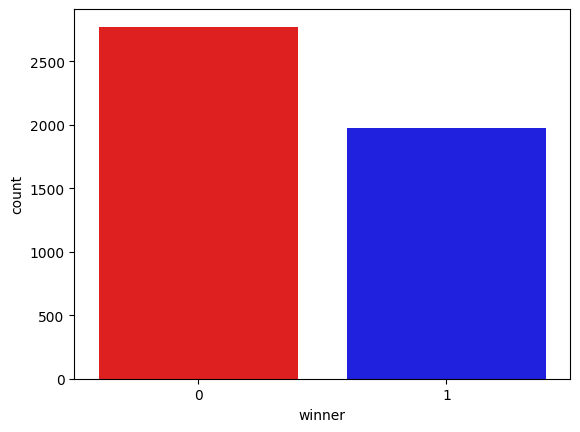

In [21]:
noencoding = df.copy()
sns.countplot(x='winner', data=noencoding, palette=['r', 'b'])

Accuracy: 59.80%


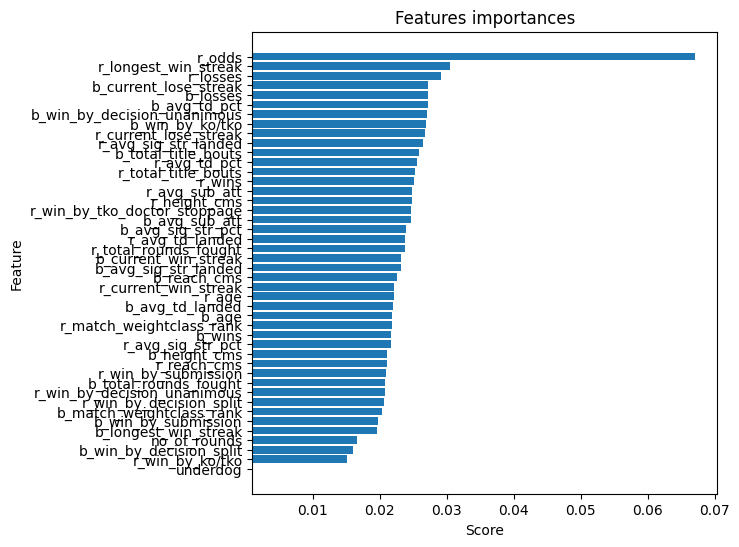

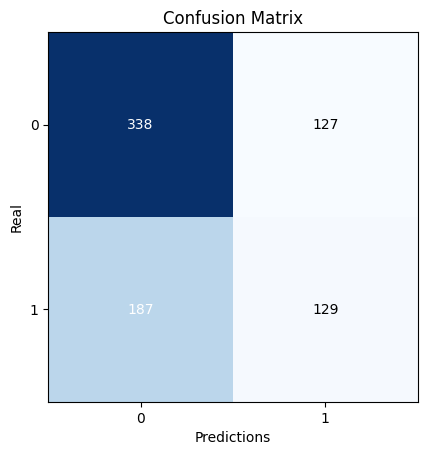

[('r_odds', 0.06610041),
 ('r_longest_win_streak', 0.02943385),
 ('r_losses', 0.02819259),
 ('b_current_lose_streak', 0.026276574),
 ('b_losses', 0.026272204),
 ('b_avg_td_pct', 0.026268177),
 ('b_win_by_decision_unanimous', 0.026055489),
 ('b_win_by_ko/tko', 0.025892487),
 ('r_current_lose_streak', 0.025731886),
 ('r_avg_sig_str_landed', 0.025521751),
 ('b_total_title_bouts', 0.0248225),
 ('r_avg_td_pct', 0.024577646),
 ('r_total_title_bouts', 0.02421537),
 ('r_wins', 0.024106406),
 ('r_avg_sub_att', 0.023802692),
 ('r_height_cms', 0.02378637),
 ('r_win_by_tko_doctor_stoppage', 0.023677565),
 ('b_avg_sub_att', 0.02366469),
 ('b_avg_sig_str_pct', 0.022961568),
 ('r_avg_td_landed', 0.022797419),
 ('r_total_rounds_fought', 0.022782598),
 ('b_current_win_streak', 0.022178672),
 ('b_avg_sig_str_landed', 0.022114394),
 ('b_reach_cms', 0.02163179),
 ('r_current_win_streak', 0.021188142),
 ('r_age', 0.021109987),
 ('b_avg_td_landed', 0.021051953),
 ('b_age', 0.020832544),
 ('r_match_weightcla

In [22]:
## tunning
columns = [
          'r_ev', 
         'b_ev', 
            'b_odds', 
          'b_pound_for_pound_rank',
            'r_weight_lbs', 
           'b_weight_lbs',
          'r_win_by_decision_majority',
           'b_win_by_decision_majority',
           'empty_arena',
           'title_bout',
            'n_of_rounds',
            'b_win_by_tko_doctor_stoppage'
          ]

noencoding.drop(columns=columns, inplace=True, errors='ignore')

weights = classifier(noencoding, 'winner')
list(weights)

In [23]:
to_save = noencoding.copy()
to_save = to_save.astype(str)
# to_save = to_save.replace(np.nan, '', regex=True)
to_save[to_save.isna()]

mongoufc.noencoding_biassed_ensamble.drop()
mongodb.send(to_save, mongoufc.noencoding_biassed_ensamble)

## Model without encoding without biass

2774 1974
0.2883922134102379
(4748, 62)
(3948, 62)


<AxesSubplot: xlabel='winner', ylabel='count'>

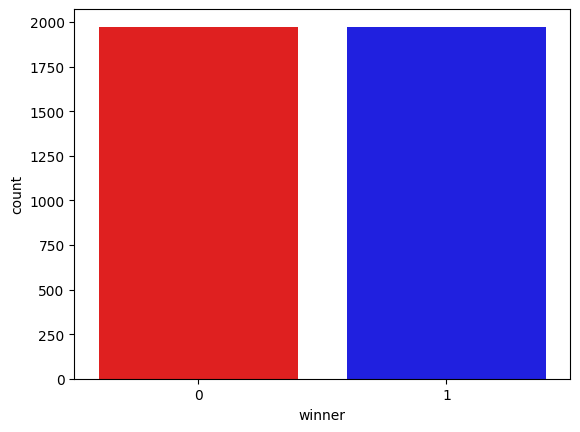

In [24]:
noencoding = df.copy()

n_red = len(noencoding[noencoding['winner'] == color_code['Red']])
n_blue = len(noencoding[noencoding['winner'] == color_code['Blue']])

print(n_red, n_blue)

frac = abs(n_red - n_blue) / max(n_red, n_blue)
target = color_code['Red'] if n_red > n_blue else color_code['Blue']


print(frac)

print(noencoding.shape)

noencoding.drop(noencoding[noencoding['winner'] == target].sample(frac=frac, random_state=1).index, inplace=True)

print(noencoding.shape)

sns.countplot(x='winner', data=noencoding, palette=['r', 'b'])

Accuracy: 57.62%


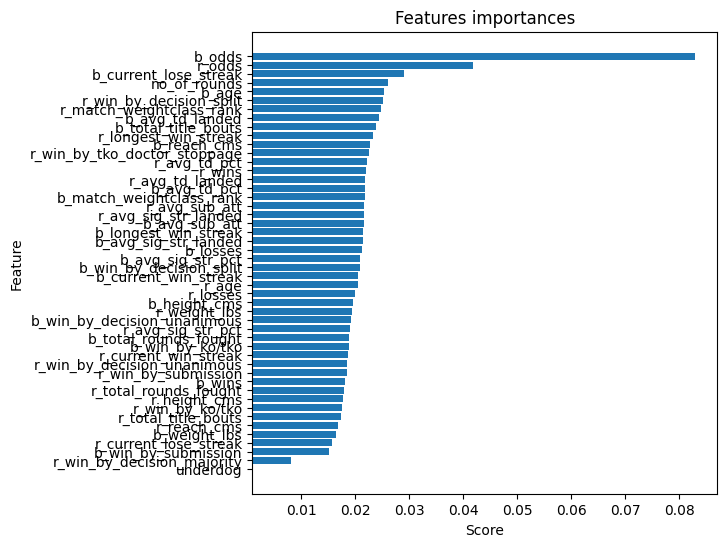

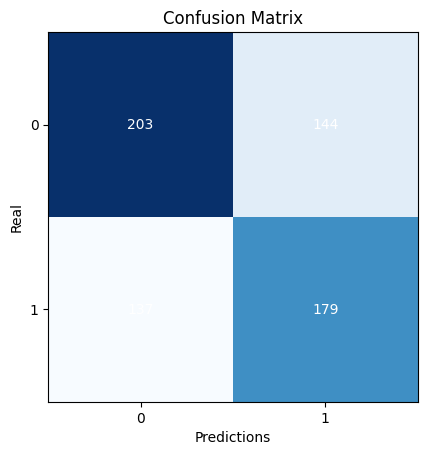

[('b_odds', 0.08200448),
 ('r_odds', 0.040894404),
 ('b_current_lose_streak', 0.02815154),
 ('no_of_rounds', 0.025090108),
 ('b_age', 0.024396414),
 ('r_win_by_decision_split', 0.024130363),
 ('r_match_weightclass_rank', 0.023855818),
 ('b_avg_td_landed', 0.02347039),
 ('b_total_title_bouts', 0.022884961),
 ('r_longest_win_streak', 0.022267044),
 ('b_reach_cms', 0.021756845),
 ('r_win_by_tko_doctor_stoppage', 0.021625567),
 ('r_avg_td_pct', 0.021177888),
 ('r_wins', 0.021041904),
 ('r_avg_td_landed', 0.020904558),
 ('b_avg_td_pct', 0.02082015),
 ('b_match_weightclass_rank', 0.020786982),
 ('r_avg_sub_att', 0.020721022),
 ('r_avg_sig_str_landed', 0.020703845),
 ('b_avg_sub_att', 0.02067567),
 ('b_longest_win_streak', 0.020462194),
 ('b_avg_sig_str_landed', 0.020443),
 ('b_losses', 0.020384487),
 ('b_avg_sig_str_pct', 0.019991597),
 ('b_win_by_decision_split', 0.019834096),
 ('b_current_win_streak', 0.019603532),
 ('r_age', 0.019490683),
 ('r_losses', 0.019077316),
 ('b_height_cms', 0.01

In [25]:
## tunning
columns = [
  'r_ev',
  'b_ev',
  'title_bout',
  'b_win_by_decision_majority',
  'b_win_by_tko_doctor_stoppage',
 'empty_arena',
  'b_pound_for_pound_rank'
          ]

noencoding.drop(columns=columns, inplace=True, errors='ignore')

weights = classifier(noencoding, 'winner')

list(weights)

In [26]:
to_save = noencoding.copy()
to_save = to_save.astype(str)
# to_save = to_save.replace(np.nan, '', regex=True)
to_save[to_save.isna()]

mongoufc.noencoding_ensamble.drop()
mongodb.send(to_save, mongoufc.noencoding_ensamble)

## Model with encoding with biass

<AxesSubplot: xlabel='winner', ylabel='count'>

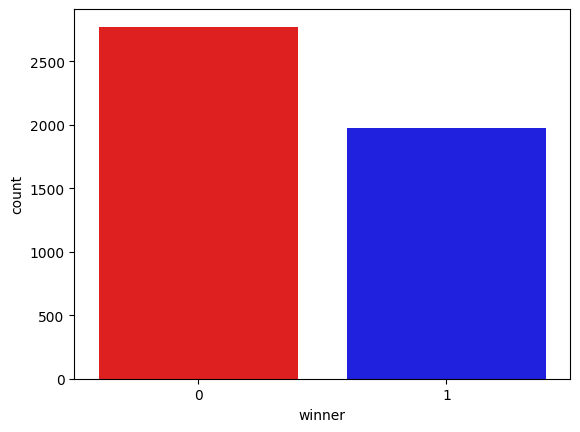

In [27]:
noencoding = df.copy()
sns.countplot(x='winner', data=noencoding, palette=['r', 'b'])

In [28]:
encoding = df.copy()
encoding.select_dtypes(include = ['category']).columns

Index(['weight_class', 'gender', 'b_stance', 'r_stance', 'better_rank'], dtype='object')

In [29]:
encoding['b_stance'].unique()

['Orthodox', 'Southpaw', 'Switch', 'Open Stance']
Categories (4, object): ['Open Stance', 'Orthodox', 'Southpaw', 'Switch']

In [30]:
weight = pd.get_dummies(encoding['weight_class'], prefix='wclass')
gender = pd.get_dummies(encoding['gender'], prefix='gender')
b_stance = pd.get_dummies(encoding['b_stance'], prefix='b')
r_stance = pd.get_dummies(encoding['r_stance'], prefix='r')
better_rank = pd.get_dummies(encoding['better_rank'], prefix='better_rank')

In [31]:
encoding = encoding.join(weight)
encoding = encoding.join(gender)
encoding = encoding.join(b_stance)
encoding = encoding.join(r_stance)
encoding = encoding.join(better_rank)

columns = [
    'weight_class',
    'gender',
    'b_stance',
    'r_stance',
    'better_rank'
]
encoding.drop(columns=columns,inplace=True)

encoding.columns = list(map(lambda x : x.lower(), list(encoding.columns)))

encoding.head()

,r_odds,b_odds,r_ev,b_ev,date,winner,title_bout,no_of_rounds,b_current_lose_streak,b_current_win_streak,...,b_orthodox,b_southpaw,b_switch,r_open stance,r_orthodox,r_southpaw,r_switch,better_rank_blue,better_rank_red,better_rank_neither
0,-150,130,66.667000,130.0,2021-10-02,0,1,5,0,1,...,1,0,0,0,1,0,0,0,1,0
1,170,-200,170.000000,50.0,2021-10-02,1,1,3,2,0,...,1,0,0,0,1,0,0,0,0,1
2,110,-130,110.000000,76.0,2021-10-02,1,1,3,1,0,...,0,1,0,0,1,0,0,0,0,1
3,-675,475,14.815000,475.0,2021-10-02,0,1,3,1,0,...,1,0,0,0,1,0,0,0,0,1
4,-135,115,74.073997,115.0,2021-10-02,1,1,3,0,2,...,1,0,0,0,1,0,0,0,0,1


Accuracy: 58.77%


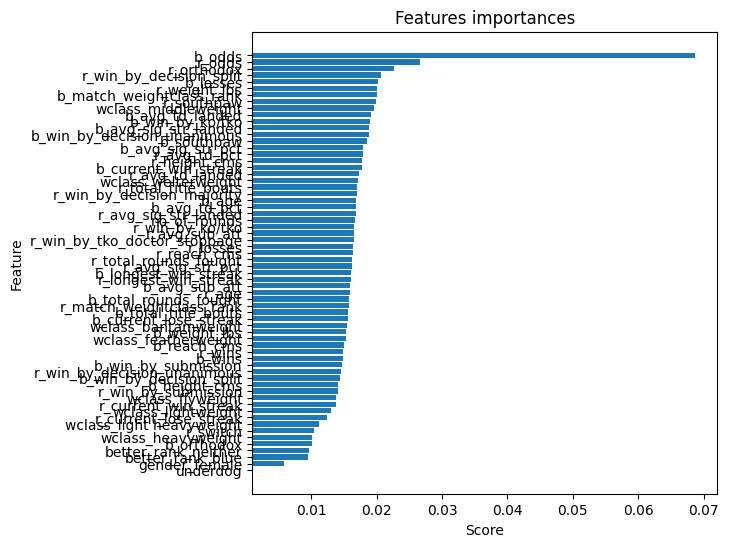

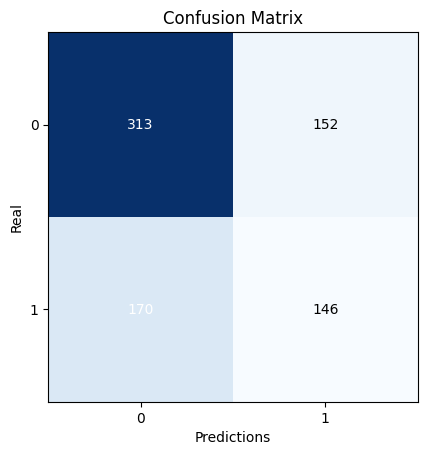

[('b_odds', 0.06770546),
 ('r_odds', 0.025587607),
 ('r_orthodox', 0.02158703),
 ('r_win_by_decision_split', 0.019603707),
 ('b_losses', 0.019179001),
 ('r_weight_lbs', 0.019091487),
 ('b_match_weightclass_rank', 0.019041903),
 ('r_southpaw', 0.018924793),
 ('wclass_middleweight', 0.018613437),
 ('b_avg_td_landed', 0.018121058),
 ('b_win_by_ko/tko', 0.017924363),
 ('b_avg_sig_str_landed', 0.017860524),
 ('b_win_by_decision_unanimous', 0.017767156),
 ('b_southpaw', 0.017449293),
 ('b_avg_sig_str_pct', 0.01692673),
 ('r_avg_td_pct', 0.016911859),
 ('r_height_cms', 0.016814183),
 ('b_current_win_streak', 0.01672276),
 ('r_avg_td_landed', 0.016362777),
 ('wclass_welterweight', 0.016158102),
 ('r_total_title_bouts', 0.015984738),
 ('r_win_by_decision_majority', 0.015917296),
 ('b_age', 0.015862428),
 ('b_avg_td_pct', 0.015798993),
 ('r_avg_sig_str_landed', 0.015782587),
 ('no_of_rounds', 0.015739048),
 ('r_win_by_ko/tko', 0.0155393155),
 ('r_avg_sub_att', 0.015522687),
 ('r_win_by_tko_docto

In [32]:
## tunning
columns = [
    'r_ev',
    'b_ev',
    'title_bout',
 'b_win_by_decision_majority',
 'b_win_by_tko_doctor_stoppage',
 'empty_arena',
 'b_pound_for_pound_rank',
 "wclass_women's bantamweight", 
 "wclass_women's flyweight",
 "wclass_women's strawweight",
 'gender_male', 
 'b_open stance', 
 'r_open stance',
     'b_switch',
 'better_rank_red'
          ]

encoding.drop(columns=columns, inplace=True, errors='ignore')

weights = classifier(encoding, 'winner')

list(weights)

In [33]:
to_save = encoding.copy()
to_save = to_save.astype(str)
to_save[to_save.isna()]
mongoufc.encoding_biassed_ensemble.drop()
mongodb.send(to_save, mongoufc.encoding_biassed_ensemble)

## Model with encoding without biass

2774 1974
0.2883922134102379
(4748, 62)
(3948, 62)


<AxesSubplot: xlabel='winner', ylabel='count'>

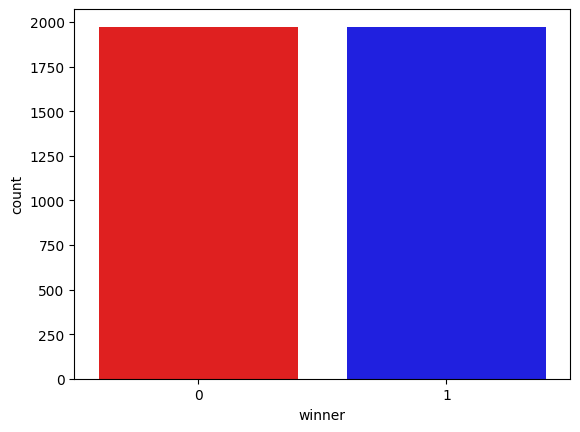

In [34]:
encoding = df.copy()

n_red = len(encoding[encoding['winner'] == color_code['Red']])
n_blue = len(encoding[encoding['winner'] == color_code['Blue']])

print(n_red, n_blue)

frac = abs(n_red - n_blue) / max(n_red, n_blue)
target = color_code['Red'] if n_red > n_blue else color_code['Blue']


print(frac)

print(encoding.shape)

encoding.drop(encoding[encoding['winner'] == target].sample(frac=frac, random_state=1).index, inplace=True)

print(encoding.shape)

sns.countplot(x='winner', data=encoding, palette=['r', 'b'])

In [35]:
weight = pd.get_dummies(encoding['weight_class'], prefix='wclass')
gender = pd.get_dummies(encoding['gender'], prefix='gender')
b_stance = pd.get_dummies(encoding['b_stance'], prefix='b')
r_stance = pd.get_dummies(encoding['r_stance'], prefix='r')
better_rank = pd.get_dummies(encoding['better_rank'], prefix='better_rank')

encoding = encoding.join(weight)
encoding = encoding.join(gender)
encoding = encoding.join(b_stance)
encoding = encoding.join(r_stance)
encoding = encoding.join(better_rank)

columns = [
    'weight_class',
    'gender',
    'b_stance',
    'r_stance',
    'better_rank'
]
encoding.drop(columns=columns,inplace=True)

encoding.columns = list(map(lambda x : x.lower(), list(encoding.columns)))

encoding.head()

,r_odds,b_odds,r_ev,b_ev,date,winner,title_bout,no_of_rounds,b_current_lose_streak,b_current_win_streak,...,b_orthodox,b_southpaw,b_switch,r_open stance,r_orthodox,r_southpaw,r_switch,better_rank_blue,better_rank_red,better_rank_neither
0,-150,130,66.667000,130.0,2021-10-02,0,1,5,0,1,...,1,0,0,0,1,0,0,0,1,0
1,170,-200,170.000000,50.0,2021-10-02,1,1,3,2,0,...,1,0,0,0,1,0,0,0,0,1
2,110,-130,110.000000,76.0,2021-10-02,1,1,3,1,0,...,0,1,0,0,1,0,0,0,0,1
3,-675,475,14.815000,475.0,2021-10-02,0,1,3,1,0,...,1,0,0,0,1,0,0,0,0,1
4,-135,115,74.073997,115.0,2021-10-02,1,1,3,0,2,...,1,0,0,0,1,0,0,0,0,1


Accuracy: 56.26%


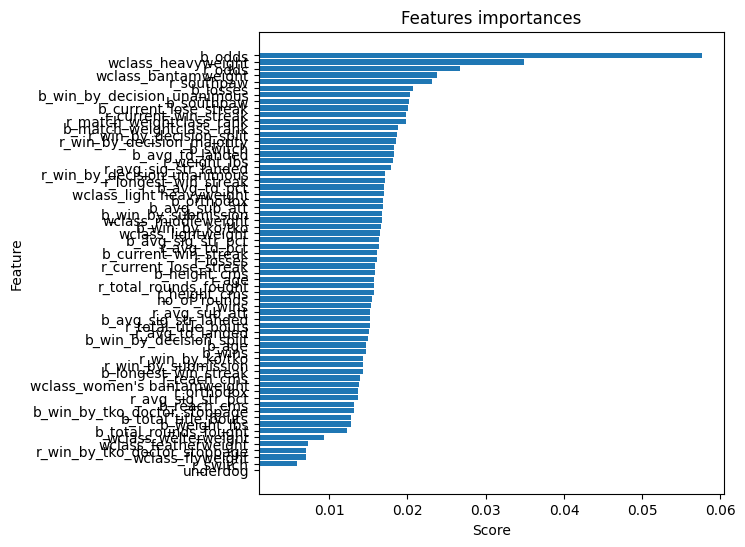

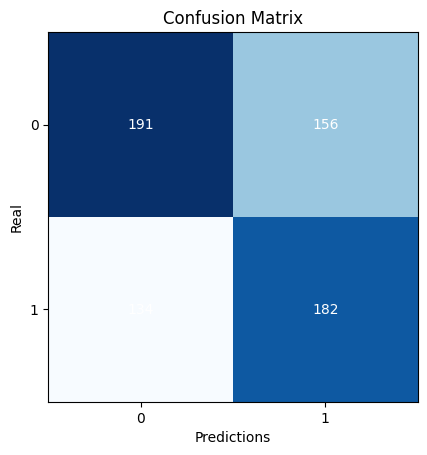

[('b_odds', 0.05659548),
 ('wclass_heavyweight', 0.03384897),
 ('r_odds', 0.025745977),
 ('wclass_bantamweight', 0.022714587),
 ('r_southpaw', 0.022192188),
 ('b_losses', 0.019756038),
 ('b_win_by_decision_unanimous', 0.019273762),
 ('b_southpaw', 0.019223014),
 ('b_current_lose_streak', 0.019093614),
 ('r_current_win_streak', 0.018764747),
 ('r_match_weightclass_rank', 0.01875692),
 ('b_match_weightclass_rank', 0.017805483),
 ('r_win_by_decision_split', 0.017639795),
 ('r_win_by_decision_majority', 0.017571196),
 ('b_switch', 0.017297318),
 ('b_avg_td_landed', 0.017283777),
 ('r_weight_lbs', 0.01717073),
 ('r_avg_sig_str_landed', 0.016843624),
 ('r_win_by_decision_unanimous', 0.016108235),
 ('r_longest_win_streak', 0.016094122),
 ('b_avg_td_pct', 0.016023403),
 ('wclass_light heavyweight', 0.01600748),
 ('b_orthodox', 0.015921379),
 ('b_avg_sub_att', 0.015851362),
 ('b_win_by_submission', 0.015804503),
 ('wclass_middleweight', 0.015781008),
 ('b_win_by_ko/tko', 0.015560678),
 ('wclass

In [36]:
## tunning
columns = [
    
 'r_ev',
 'b_ev',
 'title_bout', 
 'b_win_by_decision_majority'
 'empty_arena'
 'b_pound_for_pound_rank'
 "wclass_women's flyweight",
 "wclass_women's strawweight",
 'gender_female',
 'gender_male', 
 'b_open stance',
 'r_open stance',
 'b_win_by_decision_majority',
 'empty_arena',
 'b_pound_for_pound_rank',
 "wclass_women's flyweight",
     'better_rank_blue',
 'better_rank_red',
 'better_rank_neither',
    
          ]

encoding.drop(columns=columns, inplace=True, errors='ignore')

weights = classifier(encoding, 'winner')
list(weights)